In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/LELSD/notebooks/

/content/drive/MyDrive/LELSD/notebooks


In [ ]:
# !pip install boto3 botocore awscli --ignore-installed
# !pip install ninja
# !pip install torch==1.9.0
# !pip install torchvision==0.10.0

In [ ]:
import sys
from tqdm import tqdm
from copy import deepcopy

import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")
import models
from lelsd import LELSD
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.stylegan3_utils import StyleGAN3SampleGenerator
from utils.segmentation_utils import FaceSegmentation
from spaceUtils import * 

sys.path.insert(1, './stylegan2-ada-pytorch')

import dnnlib
import legacy

plt.style.use('fivethirtyeight')

In [ ]:
def computeScore(m1,m2):
    n = np.sum(np.logical_and(np.array(m1),np.array(m2)))
    u = np.sum(np.logical_or(np.array(m1),np.array(m2)))
    return u/n
  
def load_pretrained_model(model_name, dataset_name):
    if model_name != "biggan":
        G = models.get_model(model_name,
                             f"../pretrained/{model_name}/{model2available_dataset[model_name][dataset_name]}")
    else:
        G = models.get_model(model_name, model2available_dataset[model_name][dataset_name])
    return G

In [ ]:
model2available_dataset = {
    "stylegan2": {
        "FFHQ": "ffhq.pkl"
    },
    "stylegan3": {
        "FFHQ": "stylegan3-t-ffhq-1024x1024.pkl"
    }
}

dataset_name   = 'FFHQ'
truncation_psi = 0.7

In [ ]:
device = torch.device('cuda')
G2     = load_pretrained_model('stylegan2', dataset_name)
SG2    = StyleGAN2SampleGenerator(G=G2, device=device, truncation_psi=truncation_psi)

G3     = load_pretrained_model('stylegan3', dataset_name)
SG3    = StyleGAN3SampleGenerator(G=G3, device=device, truncation_psi=truncation_psi)

### Edit Quantifiying 1: Compute spatial change as a function of alpha

In [ ]:
face_bisenet      = models.get_model("face_bisenet", "../pretrained/face_bisenet/model.pth")
face_segmentation = FaceSegmentation(face_bisenet=face_bisenet, device=device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
ys2 = SG2.generate_batch_from_seeds([504], return_style=True)
ys3 = SG3.generate_batch_from_seeds([1002], return_style=True)

In [ ]:
ret2 = {}
alphas = [0,5,10,15,20,25,30,35,40]
img2 = edit_image_stylegan2(SG2 ,ys2['ys'], ys2['rgb_ys'], 0, 175, 4)
mask2 = (face_segmentation.predict(img2) == 17)[0,0].cpu()
for alpha in tqdm(alphas):
    modifimg2 = edit_image_stylegan2(SG2 ,ys2['ys'], ys2['rgb_ys'], -alpha, 175, 4)
    mask1 = (face_segmentation.predict(modifimg2) == 17)[0,0].cpu()
    

    ret2[alpha] = computeScore(mask1, mask2)

100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


In [ ]:
ret3 = {}
alphas = [0,5,10,15,20,25,30,35,40]
img3 = edit_image_stylegan3(SG3 ,ys3['ys'], 0, 212, 6)
mask3 = (face_segmentation.predict(img3) == 17)[0,0].cpu()
for alpha in tqdm(alphas):
    modifimg3 = edit_image_stylegan3(SG3 ,ys3['ys'], alpha, 212, 6)
    mask1 = (face_segmentation.predict(modifimg3) == 17)[0,0].cpu()

    ret3[alpha] = computeScore(mask1, mask3)

100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


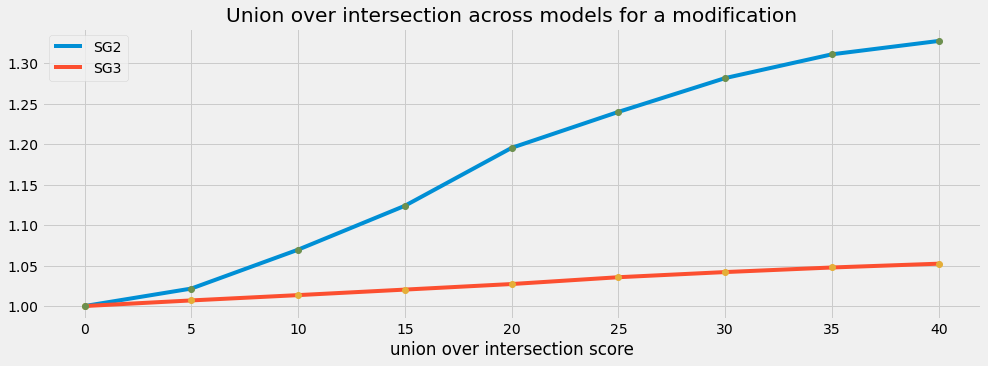

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(alphas,list(ret2.values()), label='SG2')
plt.plot(alphas,list(ret3.values()), label='SG3')
plt.plot(alphas,list(ret3.values()), 'o')
plt.plot(alphas,list(ret2.values()), 'o')
plt.title('Union over intersection across models for a modification')
plt.xlabel('alpha values')
plt.xlabel('union over intersection score')
plt.legend()

Text(0.5, 0.98, 'sensitivity of SG2 versus SG3')

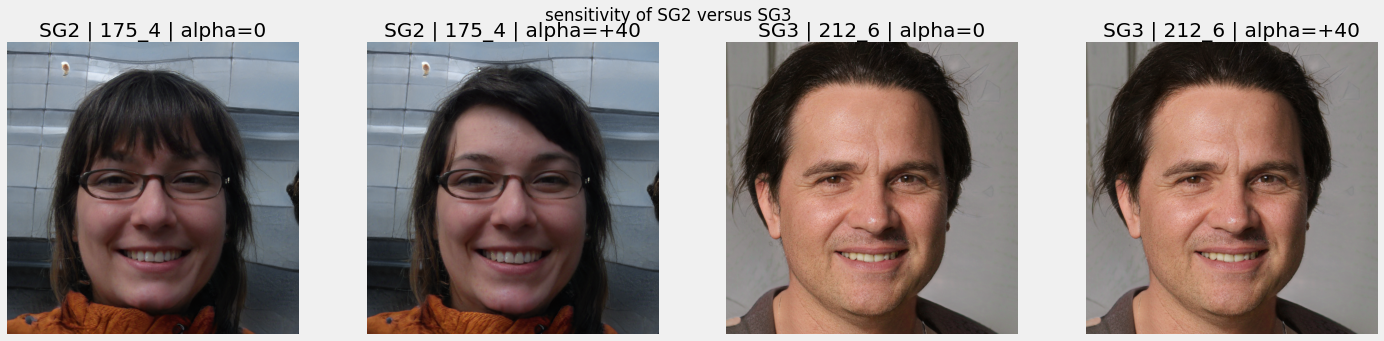

In [ ]:
fig,ax = plt.subplots(1,4, figsize=(22,5))
ax[0].imshow(img2)
ax[1].imshow(modifimg2)
ax[2].imshow(img3)
ax[3].imshow(modifimg3)

ax[0].set_title('SG2 | 175_4 | alpha=0')
ax[1].set_title('SG2 | 175_4 | alpha=+40')
ax[2].set_title('SG3 | 212_6 | alpha=0')
ax[3].set_title('SG3 | 212_6 | alpha=+40')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.suptitle('sensitivity of SG2 versus SG3')

### Edit Quantifiying 2: Compute Discriminant score change as a function of alpha

In [ ]:
from models.stylegan3 import dnnlib
from models.stylegan3 import legacy

model_path = "../pretrained/stylegan2/ffhq.pkl"
with dnnlib.util.open_url(model_path) as f:
    D2 = legacy.load_network_pkl(f)['D']
D2 = D2.eval().cuda()

# here we use SG3T
model_path = "../pretrained/stylegan3/stylegan3-t-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(model_path) as f:
    D3 = legacy.load_network_pkl(f)['D']
D3 = D3.eval().cuda()

In [ ]:
ys2 = SG2.generate_batch_from_seeds([12334], return_style=True)
ys3 = SG3.generate_batch_from_seeds([98766], return_style=True)

In [ ]:
dscoreS2a = []
dscoreS2b = []
alphas    = [0,5,10,15,20,25,30,35,40,60,80]

for alpha in tqdm(alphas):
    modifimg2 = edit_image_stylegan2(SG2 ,ys2['ys'], ys2['rgb_ys'], alpha, 175, 4, raw=True).to(torch.float64)

    dscoreS2a.append(D2(modifimg2[None],None).cpu().item())
    dscoreS2b.append(D3(modifimg2[None],None).cpu().item())    

100%|██████████| 11/11 [00:01<00:00,  7.21it/s]


In [ ]:
dscoreS3a = []
dscoreS3b = [] 
alphas    = [0,5,10,15,20,25,30,35,40,60,80]

for alpha in tqdm(alphas):
    modifimg3 = edit_image_stylegan3(SG3 ,ys3['ys'], alpha, 212, 6, raw=True).to(torch.float64)

    dscoreS3a.append(D2(modifimg3[None],None).cpu().item())
    dscoreS3b.append(D3(modifimg3[None],None).cpu().item())    

100%|██████████| 11/11 [00:01<00:00,  5.75it/s]


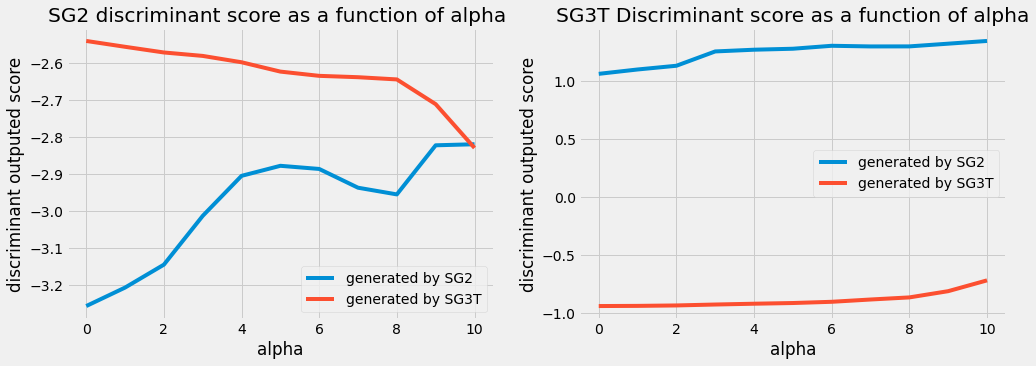

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dscoreS2a,label='generated by SG2')
ax[0].plot(dscoreS3a,label='generated by SG3T')

ax[0].set_title('SG2 discriminant score as a function of alpha ')
ax[0].set_ylabel('discriminant outputed score')
ax[0].set_xlabel('alpha')
ax[0].legend()

ax[1].plot(dscoreS2b,label='generated by SG2')
ax[1].plot(dscoreS3b,label='generated by SG3T')

ax[1].set_title('SG3T Discriminant score as a function of alpha')
ax[1].set_ylabel('discriminant outputed score')
ax[1].set_xlabel('alpha')
ax[1].legend()

Seemingly hard to interpret, from first sight it looks like the two scores across model can't be compared. Even when using the same model discriminant on SG2 generated and SG3T generated images, the score evolution is hard to interpret. 
Because of that we believe there are better ways to quantify deformation, than using discriminators.

Text(0.5, 0.98, 'sensitivity of SG2 versus SG3T')

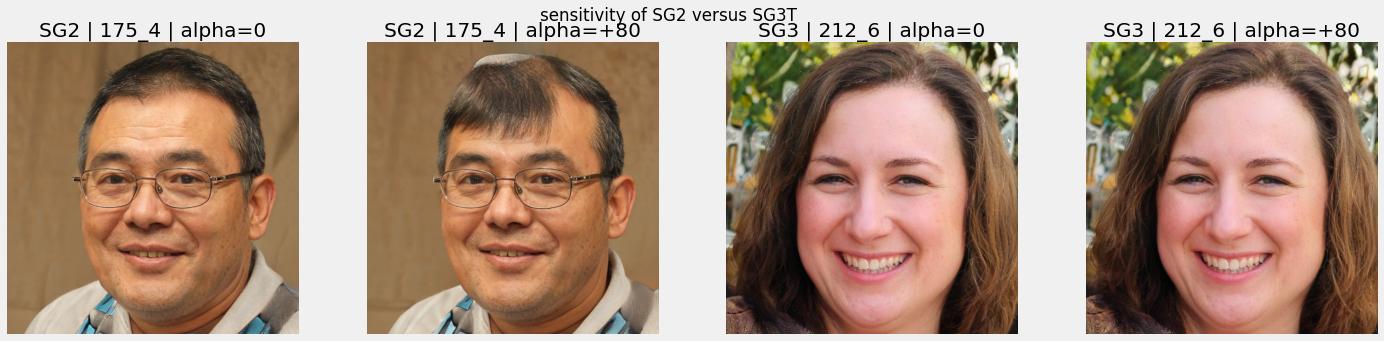

In [ ]:
img2      = edit_image_stylegan2(SG2 ,ys2['ys'], ys2['rgb_ys'], 0, 175, 4, raw=False)
modifimg2 = edit_image_stylegan2(SG2 ,ys2['ys'], ys2['rgb_ys'], 80, 175, 4, raw=False)

img3      = edit_image_stylegan3(SG3 ,ys3['ys'], 0, 212, 6, raw=False)
modifimg3 = edit_image_stylegan3(SG3 ,ys3['ys'], 80, 212, 6, raw=False)


fig,ax = plt.subplots(1,4, figsize=(22,5))
ax[0].imshow(img2)
ax[1].imshow(modifimg2)
ax[2].imshow(img3)
ax[3].imshow(modifimg3)

ax[0].set_title('SG2 | 175_4 | alpha=0')
ax[1].set_title('SG2 | 175_4 | alpha=+80')
ax[2].set_title('SG3 | 212_6 | alpha=0')
ax[3].set_title('SG3 | 212_6 | alpha=+80')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.suptitle('sensitivity of SG2 versus SG3T')